## Transfer Learning Inception V3 using Keras

In [1]:
!pip install tensorflow[gpu]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.2.1
    Uninstalling keras-3.2.1:
      Successfully uninstalled keras-3.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


In [2]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
#import matplotlib.pyplot as plt

2024-04-23 14:32:22.614067: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-23 14:32:22.614186: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-23 14:32:22.746796: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/kaggle/input/corn-leaf-disease/Corn/test'
valid_path = '/kaggle/input/corn-leaf-disease/Corn/train'


In [4]:
# Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)




87910968/87910968 [==============================] - 0s 0us/step


In [5]:
# don't train existing weights
for layer in inception.layers:
    layer.trainable = False

In [6]:
  # useful for getting number of output classes
folders = glob('/kaggle/input/corn-leaf-disease/Corn/train/*')

In [7]:
# our layers - you can add more if you want
x = Flatten()(inception.output)

In [8]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=inception.input, outputs=prediction)

In [9]:

# view the structure of the model
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0][0

In [10]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


In [11]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [12]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/kaggle/input/corn-leaf-disease/Corn/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 3757 images belonging to 4 classes.


In [13]:
test_set = test_datagen.flow_from_directory('/kaggle/input/corn-leaf-disease/Corn/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                           shuffle=False)

Found 95 images belonging to 4 classes.


In [14]:
import tensorflow as tf

class StopTrainingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') >= 0.95:
            print("\nReached 95% validation accuracy. Stopping training.")
            self.model.stop_training = True

# Define your callback
stop_training_callback = StopTrainingCallback()



In [15]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=12,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set),
  callbacks=[stop_training_callback]
)

Epoch 1/12
  1/118 [..............................] - ETA: 17:55 - loss: 1.9466 - accuracy: 0.2500

I0000 00:00:1713882773.168376      76 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


118/118 [==============================] - 74s 552ms/step - loss: 1.3881 - accuracy: 0.8344 - val_loss: 0.8982 - val_accuracy: 0.8947
Epoch 2/12
118/118 [==============================] - 51s 433ms/step - loss: 0.5811 - accuracy: 0.9207 - val_loss: 0.6691 - val_accuracy: 0.9368
Epoch 3/12
118/118 [==============================] - 51s 429ms/step - loss: 0.6127 - accuracy: 0.9268 - val_loss: 0.5702 - val_accuracy: 0.9158
Epoch 4/12
118/118 [==============================] - 51s 434ms/step - loss: 0.4642 - accuracy: 0.9401 - val_loss: 0.4622 - val_accuracy: 0.9053
Epoch 5/12
118/118 [==============================] - 51s 428ms/step - loss: 0.7270 - accuracy: 0.9329 - val_loss: 0.6120 - val_accuracy: 0.9474
Epoch 6/12
118/118 [==============================] - 50s 427ms/step - loss: 0.7357 - accuracy: 0.9303 - val_loss: 0.8316 - val_accuracy: 0.8632
Epoch 7/12
118/118 [==============================] - 51s 428ms/step - loss: 0.5127 - accuracy: 0.9481 - val_loss: 0.4102 - val_accuracy: 0.9

In [16]:
import matplotlib.pyplot as plt

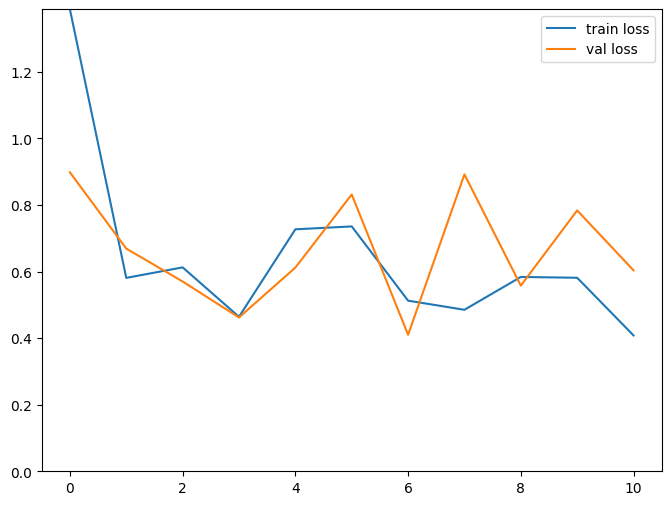

<Figure size 640x480 with 0 Axes>

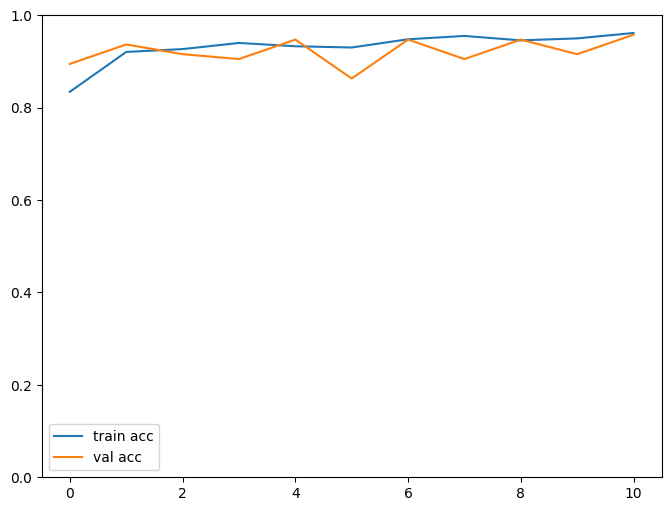

<Figure size 640x480 with 0 Axes>

In [17]:
import matplotlib.pyplot as plt

# Set figure size
plt.figure(figsize=(8, 6))  # Adjust the width and height as needed

# Plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()

# Set y-axis limits from 0 to the maximum loss
plt.ylim(0, max(max(r.history['loss']), max(r.history['val_loss'])))

plt.show()
plt.savefig('LossVal_loss')

# Set figure size
plt.figure(figsize=(8, 6))  # Adjust the width and height as needed

# Plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()

# Set y-axis limits from 0 to 1 (accuracy ranges from 0 to 1)
plt.ylim(0, 1)

plt.show()
plt.savefig('AccVal_acc')



In [18]:
# save it as a h5 file

model.save('corn_model_inception_final.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [19]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [20]:
scores = model.evaluate(test_set)
scores

3/3 [==============================] - 0s 91ms/step - loss: 0.6037 - accuracy: 0.9579


[0.6037480235099792, 0.9578947424888611]

In [21]:
true_labels = test_set.labels
predicted_labels = model.predict(test_set)
# Convert predicted probabilities to class labels
predicted_classes = np.argmax(predicted_labels, axis=1)


3/3 [==============================] - 2s 84ms/step


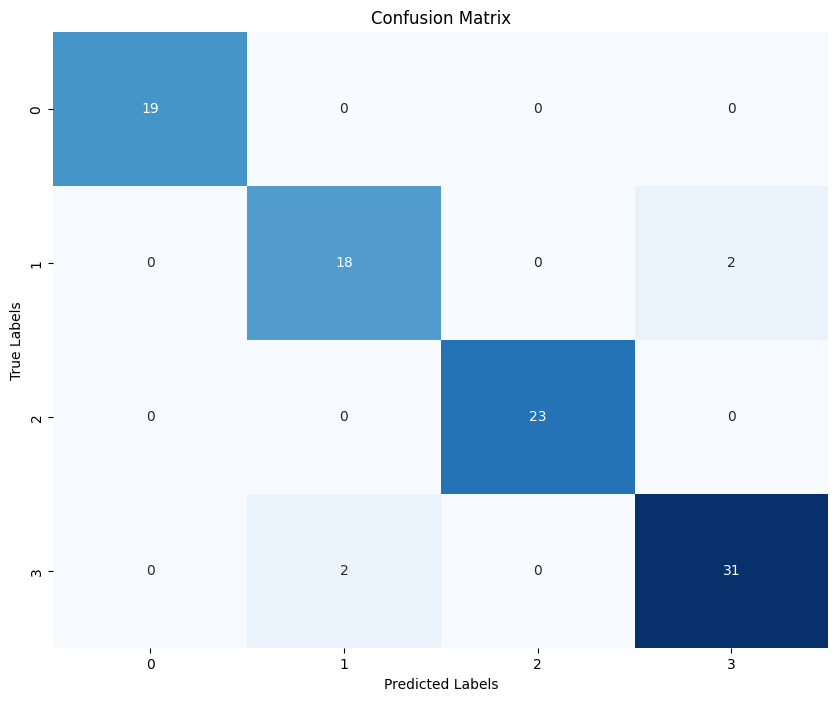

In [22]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(true_labels, predicted_classes)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()